**Importing Useful Libraries and Data**

In [ ]:
import numpy as np
import pandas as pd
import cv2
!pip install torchxrayvision
import torchxrayvision as xrv
!pip install wandb
import wandb

     |████████████████████████████████| 42.4MB 75kB/s 
     |████████████████████████████████| 1.9MB 41.8MB/s 
     |████████████████████████████████| 1.8MB 3.6MB/s 
     |████████████████████████████████| 133kB 40.6MB/s 
     |████████████████████████████████| 163kB 30.0MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=737e712b4e70d6dddb6a0c5ed64ff227b327cc33538f48fbcf6391e20f039be1
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=0c64b78297817b8c69163c85a28209e732f37c1fdb3a88cea4caa60484d99555
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for path

In [ ]:
wandb.init(project='covid_iisc')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir='/content/drive/MyDrive/COVID_IISC/covid-chestxray-dataset-master/images'
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(320)])
data = xrv.datasets.COVID19_Dataset(imgpath=data_dir, csvpath='/content/drive/MyDrive/COVID_IISC/covid-chestxray-dataset-master/metadata.csv',transform=transform, views=["PA", "AP","AP Supine","AP erect"])

**Train, val, test split**

In [ ]:

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
train,_ = train_test_split(data, test_size=1 - train_ratio)
val,test = train_test_split(_, test_size=test_ratio/(test_ratio + validation_ratio)) 
print(len(train),len(val),len(test))

522 105 70


**Computing the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)**

In [ ]:
def match_histogram(source, template):
    """
    Adjust the pixel values of a gray-scale image such that its histogram
    matches that of a target image
    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interpolated_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    hist_matched_img = interpolated_t_values[bin_idx].reshape(oldshape)
    result = np.array(hist_matched_img, dtype='uint8')

    return result


def subhist(image_pdf, minimum, maximum, normalize):
    """
    Compute the subhistogram between [minimum, maximum] of a given histogram image_pdf
    :param image_pdf: numpy.array
    :param minimum: int
    :param maximum: int
    :param normalize: boolean
    :return: numpy.array
    """
    hi = np.zeros(shape=image_pdf.shape)
    total = 0
    for idx in range(minimum, maximum+1):
        total += image_pdf[idx]
        hi[idx] = image_pdf[idx]
    if normalize:
        for idx in range(minimum, maximum+1):
            hi[idx] /= total
    return hi


def CDF(hist):
    """
    Compute the CDF of the input histogram
    :param hist: numpy.array()
    :return: numpy.array()
    """
    cdf = np.zeros(shape=hist.shape)
    cdf[0] = hist[0]
    for idx in range(1, len(hist)):
        cdf[idx] = cdf[idx - 1] + hist[idx]
    return cdf


def BEASF(image, gamma):
    """
    Compute the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)
    A python implementation of the original MATLAB code:
    https://mathworks.com/matlabcentral/fileexchange/47517-beasf-image-enhancer-for-gray-scale-images
    The algorithm is introduced by E. F. Arriaga-Garcia et al., in the research paper:
    https://ieeexplore.ieee.org/document/6808563
    :param image: numpy.ndarray
    :param gamma: float [0, 1]
    :return: numpy.ndarray
    """
    m = int(np.mean(image, dtype=np.int32))
    h = np.histogram(image, bins=256)[0] / (image.shape[0] * image.shape[1])
    h_lower = subhist(image_pdf=h, minimum=0, maximum=m, normalize=True)
    h_upper = subhist(image_pdf=h, minimum=m, maximum=255, normalize=True)

    cdf_lower = CDF(hist=h_lower)
    cdf_upper = CDF(hist=h_upper)

    # Find x | CDF(x) = 0.5
    half_low = 0
    for idx in range(0, m+2):
        if cdf_lower[idx] > 0.5:
            half_low = idx
            break
    half_up = 0
    for idx in range(m, 256):
        if cdf_upper[idx + 1] > 0.5:
            half_up = idx
            break

    # sigmoid CDF creation
    tones_low = np.arange(0, m+1, 1)
    x_low = 5.0 * (tones_low - half_low) / m  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_low = 1 / (1 + np.exp(-gamma * x_low))  # lower sigmoid

    tones_up = np.arange(m, 256, 1)
    x_up = 5.0 * (tones_up - half_up) / (255 - m)  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_up = 1 / (1 + np.exp(-gamma * x_up))  # upper sigmoid

    mapping_vector = np.zeros(shape=(256,))
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32(m * s_low[idx])

    minimum = mapping_vector[0]
    maximum = mapping_vector[m]
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32((m / (maximum - minimum)) * (mapping_vector[idx] - minimum))
    for idx in range(m+1, 256):
        mapping_vector[idx] = np.int32(m + (255 - m) * s_up[idx - m - 1])

    minimum = mapping_vector[m + 1]
    maximum = mapping_vector[255]
    for idx in range(m+1, 256):
        mapping_vector[idx] = (255 - m) * (mapping_vector[idx] - minimum) / (maximum - minimum) + m

    res = copy.deepcopy(image)
    res[:, :] = mapping_vector[image[:, :]]
    return res

**DataLoaders and batches**

In [ ]:
train_dataloader=torch.utils.data.DataLoader(train,batch_size=29,shuffle=True)
def get_train_batches(batch_size):
  batch=next(iter(train_dataloader))
  x_train=batch['img']
  y_train=torch.zeros(batch_size,1)
  for i in range(batch_size):
    y_train[i]=batch['lab'][i][3] 
  return x_train, y_train

In [ ]:
test_dataloader=torch.utils.data.DataLoader(test,batch_size=70,shuffle=True)
def get_test_batches(batch_size):
  batch=next(iter(test_dataloader))
  x_test=batch['img']
  y_test=torch.zeros(batch_size,1)
  for i in range(batch_size):
    y_test[i]=batch['lab'][i][3] 
  return x_test, y_test

In [ ]:
val_dataloader=torch.utils.data.DataLoader(val,batch_size=15,shuffle=True)
def get_val_batches(batch_size):
  batch=next(iter(val_dataloader))
  x_val=batch['img']
  y_val=torch.zeros(batch_size,1)
  for i in range(batch_size):
    y_val[i]=batch['lab'][i][3] 
  return x_val, y_val

**Preprocessing Function -- Cocatenate BEASF, CLAHE with the original image**

In [ ]:
preprocess = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
gray_preprocess=transforms.Compose([transforms.Normalize([0.5],[0.22])])


def preprocess_img(batch,batch_size,num_channels):
  preprocessed_batch=torch.zeros(batch_size,num_channels,320,320)
  for i,img in enumerate(batch):
    hist=match_histogram(img.numpy().astype(int),data[0]['img'].astype(int))
    beasf=BEASF(hist,gamma=0.5)
    hist=torch.Tensor(hist).view(320,-1,1)
    hist=hist.numpy()
    clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    X_clahe = clahe.apply(hist.astype(np.uint8))
    X_clahe = np.array(np.expand_dims(a=X_clahe, axis=-1))
    X_clahe = torch.Tensor(X_clahe).view(1,-1,320)
    X_clahe = X_clahe.numpy()
    image = np.concatenate((beasf,X_clahe,img),axis=0)
    image = preprocess(torch.Tensor(image))
    preprocessed_batch[i]=image
  return preprocessed_batch.to(device)


**Functions to get accuracy and prediction labels**

In [ ]:
def get_acc(preds,labels):
  for i in range(len(preds)):
    if (preds[i]>=0.5):
      preds[i]=1
    else:
      preds[i]=0
  return torch.mean((labels == preds).float())


In [ ]:
def get_preds(preds):
  for i in range(len(preds)):
    if (preds[i]>=0.5):
      preds[i]=1
    else:
      preds[i]=0
  return preds


**Defining the model architecture**

In [ ]:
model=models.densenet121(pretrained=True).to(device)
inp=model.classifier.in_features
model.classifier=nn.Linear(inp,18).to(device)
dropout=nn.Dropout(p=0.2).to(device)
classifier=nn.Linear(18,1).to(device)
sigmoid=nn.Sigmoid()
loss_fn=nn.BCELoss()
lr=0.0005
optimizer=torch.optim.Adam(classifier.parameters(),lr=lr)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
beasf_clahe_model=nn.Sequential(model,dropout,classifier,sigmoid)

**Training Loop**

In [ ]:

def train_data(epochs,optimizer,loss_fn,model,drop,classifier,sigmoid,train_batch_size,val_batch_size):
  train_iter=int(len(train)/train_batch_size)
  val_iter=int(len(val)/val_batch_size)
  for i in range(epochs):
    idx=0
    epoch_loss=[]
    epoch_acc=[]
    val_loss=[]
    val_acc=[]
    for j in range(train_iter):
      batch_x,batch_y=get_train_batches(train_batch_size)
      batch_x=preprocess_img(batch_x,train_batch_size,num_channels=3)
      batch_y=torch.autograd.Variable(batch_y).to(device)
      optimizer.zero_grad()
      out=model(batch_x)
      out=drop(out)
      out=classifier(out)
      out1=sigmoid(out)
      loss=loss_fn(out1,batch_y)
      loss.backward()
      optimizer.step()
      epoch_loss.append(loss.item())
      acc=get_acc(out1,batch_y)
      epoch_acc.append(acc)
      if (train_iter%3==0):
        wandb.log({'loss':np.mean(epoch_loss),'acc':acc})
        print('Epoch {} ____ train_iter {} ::::: Loss-> {} ::::: Accc-> {}'.format(i,j,np.mean(epoch_loss),acc))
    for k in range(val_iter):
      batch_x_v,batch_y_v=get_val_batches(val_batch_size)
      batch_x_v=preprocess_img(batch_x_v,val_batch_size,num_channels=3)
      batch_y_v=torch.autograd.Variable(batch_y_v).to(device)
      with torch.no_grad():
        model.eval()
        classifier.eval()
        out_v=model(batch_x_v)
        out_v=drop(out_v)
        out_v=classifier(out_v)
        out1_v=sigmoid(out_v)
        loss_v=loss_fn(out1_v,batch_y_v)
        acc_v=get_acc(out1_v,batch_y_v)
        val_loss.append(loss_v.item())
        val_acc.append(acc_v)
        wandb.log({'val_loss': np.mean(val_loss),'val_acc':acc_v})
        print('val_iter {} ::::: Val_Loss-> {} ::::: Val_Acc -> {}'.format(k,np.mean(val_loss),acc_v))


In [ ]:
train_data(50,optimizer,loss_fn,model,dropout,classifier,sigmoid,29,15)

Epoch 0 ____ train_iter 0 ::::: Loss-> 0.6665712594985962 ::::: Accc-> 0.6896551847457886
Epoch 0 ____ train_iter 1 ::::: Loss-> 0.6712582409381866 ::::: Accc-> 0.5517241358757019
Epoch 0 ____ train_iter 2 ::::: Loss-> 0.6931976675987244 ::::: Accc-> 0.41379308700561523
Epoch 0 ____ train_iter 3 ::::: Loss-> 0.6879612952470779 ::::: Accc-> 0.5862069129943848
Epoch 0 ____ train_iter 4 ::::: Loss-> 0.6908080577850342 ::::: Accc-> 0.5862069129943848
Epoch 0 ____ train_iter 5 ::::: Loss-> 0.6874543329079946 ::::: Accc-> 0.5862069129943848
Epoch 0 ____ train_iter 6 ::::: Loss-> 0.6890863435609 ::::: Accc-> 0.48275861144065857
Epoch 0 ____ train_iter 7 ::::: Loss-> 0.6892700269818306 ::::: Accc-> 0.6206896305084229
Epoch 0 ____ train_iter 8 ::::: Loss-> 0.6881607174873352 ::::: Accc-> 0.5862069129943848
Epoch 0 ____ train_iter 9 ::::: Loss-> 0.6903489053249359 ::::: Accc-> 0.41379308700561523
Epoch 0 ____ train_iter 10 ::::: Loss-> 0.6923326308077032 ::::: Accc-> 0.4482758641242981
Epoch 0 _

In [ ]:
path='/content/drive/MyDrive/COVID_IISC'
torch.save(beasf_clahe_model,os.path.join(path,'beasf_clahe_model.pt'))

**Evaluating the model**

In [ ]:
test_batch_size=70
test_iter=1
def evaluate(optimizer,loss_fn,model,drop,classifier,sigmoid=sigmoid):
  test_losses=[]
  preds=[]
  true_labels=[]
  test_accuracy=[]
  for j in range(test_iter):
    batch_x,batch_y=get_test_batches(test_batch_size)
    batch_x=preprocess_img(batch_x,test_batch_size,num_channels=3)
    batch_y=torch.autograd.Variable(batch_y).to(device)
    true_labels.append(batch_y)
    with torch.no_grad():
      optimizer.zero_grad()
      model.eval()
      classifier.eval()
      out=model(batch_x)
      out=drop(out)
      out=classifier(out)
      out1=sigmoid(out)
      preds.append(out1)
      loss=loss_fn(out1,batch_y)
      test_losses.append(loss.item())
      test_acc=get_acc(out1,batch_y)
      test_accuracy.append(test_acc)
      predictions=get_preds(out1)
  return test_accuracy,predictions.cpu().numpy(),batch_y.cpu().numpy()        

**Accuracy and F1 score**

In [ ]:
acc,preds,labels=evaluate(optimizer,loss_fn,model,dropout,classifier,sigmoid)
print('The accuracy on test data is {}'.format(acc))

The accuracy on test data is [tensor(0.6571, device='cuda:0')]


In [ ]:
import sklearn
f1=f1_score(labels,preds)
print('f1 score is {}'.format(f1))
conf_mat=sklearn.metrics.confusion_matrix(labels,preds)
print('confusion matrix:::{}'.format(conf_mat))

f1 score is 0.7931034482758621
confusion matrix:::[[ 0 24]
 [ 0 46]]


**GRAD_CAM for Analysis and Interpretability**

In [ ]:
!pip install pytorch-gradcam
from gradcam import GradCAMpp,GradCAM
from gradcam.utils import visualize_cam

gradcam1=GradCAMpp.from_config(model_type='densenet',arch=model,layer_name='features_norm5')

     |████████████████████████████████| 6.0MB 3.7MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5270 sha256=e023053f203fc8fea0b37f922d6c6ad445f0b5212ca1dcfb872a91c75f9badd4
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


<Figure size 432x288 with 0 Axes>

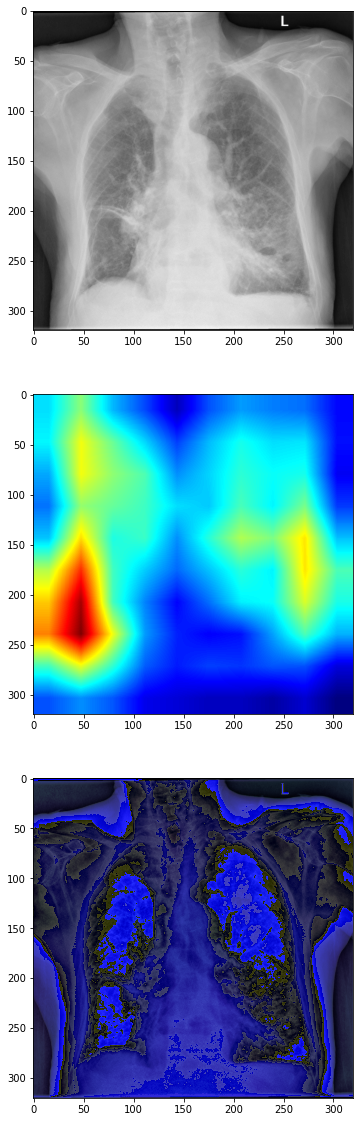

In [ ]:
id=0 #id of the image that is to be visualized
batch,_=get_test_batches(70)
torch_img=preprocess_img(batch,70,3)
torch_img=torch_img[id].view(1,3,320,-1)
mask, _ = gradcam1(torch_img,class_idx=_[id].numpy().astype(int))
heatmap, result = visualize_cam(mask, torch_img)
heatmap=transforms.ToPILImage()(heatmap)
result=transforms.ToPILImage()(result)
plt.figure()
f, axarr = plt.subplots(3,1,figsize=(20,20)) 
axarr[0].imshow(batch[id].squeeze(0),cmap='gray',interpolation='nearest')
axarr[1].imshow(heatmap,interpolation='nearest')
axarr[2].imshow(result,interpolation='nearest')